
## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [0]:
# Load CSV file into DataFrame with correct headers
df = spark.read.csv("/FileStore/tables/heart.csv", header=True, inferSchema=True)

# Check the first few rows
df.show(5)


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

In [0]:
# Create a temporary SQL table with correct column names
df.createOrReplaceTempView("heart_data")

In [0]:
%sql

/* Query the created temp table in a SQL cell */

select * from `heart_data` 
LIMIT 10

Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [0]:
%sql
-- Example query to show all data
SELECT * FROM heart_data LIMIT 10;

-- Example query to find the average cholesterol by age
SELECT Age, AVG(Cholesterol) AS Avg_Cholesterol
FROM heart_data
GROUP BY Age;


Age,Avg_Cholesterol
31,244.5
65,207.57142857142858
53,181.03030303030303
34,163.28571428571428
28,132.0
76,155.0
44,249.57894736842104
47,193.42105263157896
52,200.27777777777777
40,229.3846153846154


In [0]:
from pyspark.sql.functions import count, when, isnull

# Check for missing values in Python
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



In [0]:
#Handling the categorical variables

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sex", outputCol="Sex_index")
indexer = StringIndexer(inputCol="ChestPainType", outputCol="ChestPainType_index")
indexer = StringIndexer(inputCol="RestingECG", outputCol="RestingECG_index")
indexer = StringIndexer(inputCol="ExerciseAngina", outputCol="ExerciseAngina_index")
indexer = StringIndexer(inputCol="ST_Slope", outputCol="ST_Slope_index")

df = indexer.fit(df).transform(df)

In [0]:
#Handling the numeric variables by scaling

from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# Vectorize numeric columns
numeric_columns = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="numeric_features")
df_vector = assembler.transform(df)

# Apply Min-Max Scaling
scaler = MinMaxScaler(inputCol="numeric_features", outputCol="scaled_numeric_features")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)


In [0]:
#Splitting Data into Train and Test Sets
train, test = df_scaled.randomSplit([0.8, 0.2], seed=123)

In [0]:
#preforming Logistic Regression on dataset
from pyspark.ml.classification import LogisticRegression

# Define the model
lr = LogisticRegression(featuresCol="scaled_numeric_features", labelCol="HeartDisease")

# Train the model
lr_model = lr.fit(train)

# Make predictions
predictions = lr_model.transform(test)


In [0]:
#Evaluating Model Performance
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")


ROC-AUC: 0.7033788174139052


In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="scaled_numeric_features", labelCol="HeartDisease")
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

# Evaluate Random Forest model
roc_auc_rf = evaluator.evaluate(rf_predictions)
print(f"Random Forest ROC-AUC: {roc_auc_rf}")


Random Forest ROC-AUC: 0.7782651072124757


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluator for accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7846153846153846


In [0]:
evaluator_precision = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

# Recall
evaluator_recall = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

# F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="HeartDisease", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1-Score: {f1_score}")

Precision: 0.7846153846153847
Recall: 0.7846153846153847
F1-Score: 0.7846153846153845


In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluator for AUC
evaluator_roc = BinaryClassificationEvaluator(labelCol="HeartDisease", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_roc.evaluate(predictions)
print(f"AUC (ROC): {auc}")

AUC (ROC): 0.8262941303876977


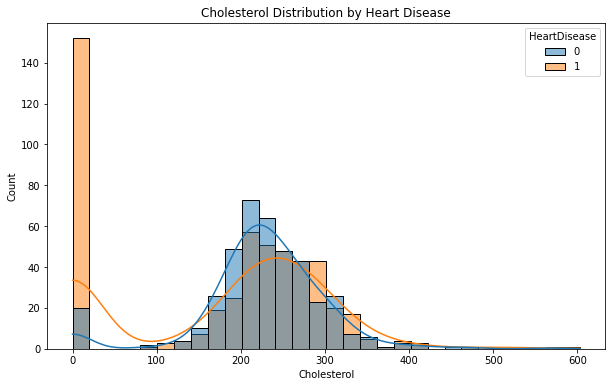

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Cholesterol based on Heart Disease
plt.figure(figsize=(10, 6))
sns.histplot(data=df.toPandas(), x="Cholesterol", hue="HeartDisease", kde=True, bins=30)
plt.title("Cholesterol Distribution by Heart Disease")
plt.show()


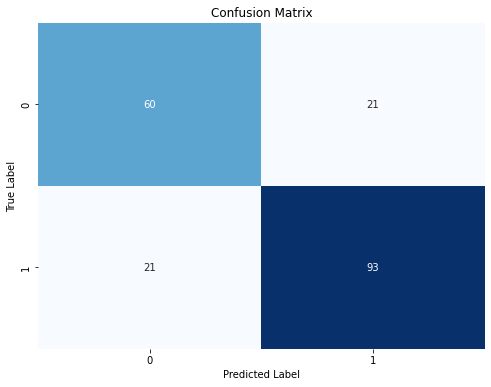

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you've converted predictions to Pandas
y_true = test.select("HeartDisease").toPandas()
y_pred = rf_predictions.select("prediction").toPandas()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


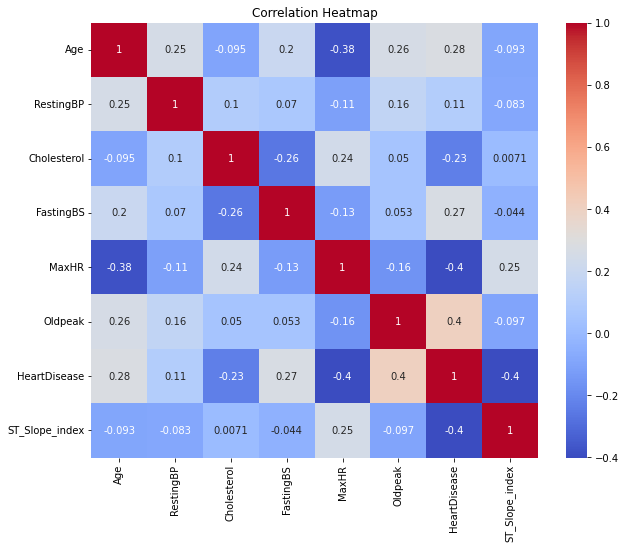

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of correlation
plt.figure(figsize=(10,8))
sns.heatmap(df.toPandas().corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()